# Health Insurance Risk Classifier
This project classifies individuals into health insurance risk categories based on their health metrics.
It uses a simple rule-based approach to categorize risk levels.

Author Carmine Giardino

## Step 1: Import Necessary Libraries

Import all required Python libraries for data manipulation, analysis, database operations, and visualization.


In [1]:
# Import pandas for data handling
# Ref: https://pandas.pydata.org/docs/user_guide/index.html
import pandas as pd
# Import numpy for numerical operations
# Ref: https://numpy.org/doc/stable/user/absolute_beginners.html
import numpy as np
# Import sqlite3 for database operations
# Ref: https://docs.python.org/3/library/sqlite3.html
import sqlite3
# Import matplotlib for plotting
# Ref: https://matplotlib.org/stable/tutorials/introductory/pyplot.html
import matplotlib.pyplot as plt
# Import seaborn for advanced visualizations
# Ref: https://seaborn.pydata.org/tutorial.html
import seaborn as sns

## Step 2: Read the Health Insurance Data from CSV File

Load the health insurance dataset from a CSV file into a pandas DataFrame for analysis.


In [2]:
# Read CSV file into a pandas DataFrame
# Ref: https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html
path = './data/health_insurance_data.csv'
df = pd.read_csv(path)
print("Data loaded successfully.")
# Display the first 5 rows to understand the data structure
# Ref: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.head.html
print(df.head())

Data loaded successfully.
    age     sex     bmi  children smoker     region      charges
0  19.0  female  27.900       0.0    yes  southwest  16884.92400
1  18.0    male  33.770       1.0     no  southeast   1725.55230
2  28.0    male  33.000       3.0     no  southeast   4449.46200
3  33.0    male  22.705       0.0     no  northwest  21984.47061
4  32.0    male  28.880       0.0     no  northwest   3866.85520


## Step 3: Clean the Data by Handling Missing Values

Handle missing values in the dataset using appropriate imputation strategies: mean for numeric columns and mode for categorical columns.


In [3]:
# Fill missing values in numeric columns with mean
# This is a common imputation strategy for numerical data
# Ref: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.fillna.html
for col in df.select_dtypes(include=[np.number]).columns:
    df[col] = df[col].fillna(df[col].mean())

# Fill missing values in non-numeric columns with mode is the most frequent value, suitable for categorical data
# Ref: https://pandas.pydata.org/docs/reference/api/pandas.Series.mode.html
for col in df.select_dtypes(exclude=[np.number]).columns:
    mode = df[col].mode()[0] if not df[col].mode().empty else None
    df[col] = df[col].fillna(mode)

print("Missing values handled.")
# Check for remaining missing values
# Ref: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.isnull.html
print(df.isnull().sum())

Missing values handled.
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


### Step 3.1: Encode Categorical Variables

Convert categorical text variables (sex, smoker, region) into numerical format using binary encoding and one-hot encoding for use in analysis.


In [4]:
# Encode categorical variables for analysis
# Machine learning models require numerical input, so we convert text categories to numbers
# sex: male=1, female=0 (binary encoding)
# Ref: https://pandas.pydata.org/docs/reference/api/pandas.Series.map.html
df['sex_encoded'] = df['sex'].map({'male': 1, 'female': 0})

# smoker: yes=1, no=0 (binary encoding)
df['smoker_encoded'] = df['smoker'].map({'yes': 1, 'no': 0})

# region: use one-hot encoding
# One-hot encoding converts categorical text into a numerical format without implying any ordinal relationship between regions.
# Each region becomes a separate binary column
# Ref: https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html
region_dummies = pd.get_dummies(df['region'], prefix='region')
# Concatenate the one-hot encoded columns with the original DataFrame
# Ref: https://pandas.pydata.org/docs/reference/api/pandas.concat.html
df = pd.concat([df, region_dummies], axis=1)

print("Categorical variables encoded.")
print(df.head())
print(f"\nDataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

Categorical variables encoded.
    age     sex     bmi  children smoker     region      charges  sex_encoded  \
0  19.0  female  27.900       0.0    yes  southwest  16884.92400            0   
1  18.0    male  33.770       1.0     no  southeast   1725.55230            1   
2  28.0    male  33.000       3.0     no  southeast   4449.46200            1   
3  33.0    male  22.705       0.0     no  northwest  21984.47061            1   
4  32.0    male  28.880       0.0     no  northwest   3866.85520            1   

   smoker_encoded  region_northeast  region_northwest  region_southeast  \
0               1             False             False             False   
1               0             False             False              True   
2               0             False             False              True   
3               0             False              True             False   
4               0             False              True             False   

   region_southwest  
0        

## Step 4: Normalize Numeric Features for Better Comparison

Apply min-max normalization to scale numeric features to a [0, 1] range, making them comparable and suitable for analysis.


In [5]:
# Preserve original charges for later correlation analysis
# Ref: https://pandas.pydata.org/docs/reference/api/pandas.Series.copy.html
df['charges_original'] = df['charges'].copy()

# Identify numeric columns
# Ref: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.select_dtypes.html
numeric_cols = df.select_dtypes(include=[np.number]).columns
# Exclude charges_original from normalization
numeric_cols = [col for col in numeric_cols if col != 'charges_original']

# Normalize using manual min-max scaling (scales values to range [0, 1])
# Formula: normalized = (value - min) / (max - min)
# Ref: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
for col in numeric_cols:
    min_val = df[col].min()
    max_val = df[col].max()
    df[col] = (df[col] - min_val) / (max_val - min_val)
print("Numeric features normalized.")
print(df.head())

Numeric features normalized.
        age     sex       bmi  children smoker     region   charges  \
0  0.021739  female  0.321227       0.0    yes  southwest  0.251611   
1  0.000000    male  0.479150       0.2     no  southeast  0.009636   
2  0.217391    male  0.458434       0.6     no  southeast  0.053115   
3  0.326087    male  0.181464       0.0     no  northwest  0.333010   
4  0.304348    male  0.347592       0.0     no  northwest  0.043816   

   sex_encoded  smoker_encoded  region_northeast  region_northwest  \
0          0.0             1.0             False             False   
1          1.0             0.0             False             False   
2          1.0             0.0             False             False   
3          1.0             0.0             False              True   
4          1.0             0.0             False              True   

   region_southeast  region_southwest  charges_original  
0             False              True       16884.92400  
1      

### Step 4.1: Save the Data to SQLite Database

Save both the original and processed datasets to a SQLite database to ensure data persistence and enable SQL-based queries.


In [6]:
# Create SQLite database connection
db_path = './data/health_insurance.db'
# Connect to SQLite database (it will be created if it doesn't exist)
# Ref: https://docs.python.org/3/library/sqlite3.html#sqlite3.connect
conn = sqlite3.connect(db_path)

# Save the processed data to SQLite
# Ref: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_sql.html
df.to_sql('health_insurance_processed', conn, if_exists='replace', index=False)

# Also save the original data (before normalization) if needed
df_original = pd.read_csv(path)
df_original.to_sql('health_insurance_original', conn, if_exists='replace', index=False)

# Close the connection
# Ref: https://docs.python.org/3/library/sqlite3.html#sqlite3.Connection.close
conn.close()

print(f"Data saved to SQLite database at: {db_path}")
print("Tables created: 'health_insurance_original' and 'health_insurance_processed'")

Data saved to SQLite database at: ./data/health_insurance.db
Tables created: 'health_insurance_original' and 'health_insurance_processed'


## Step 5: Define Risk Classification Rules Based on Health Metrics

Create a rule-based classification function that assigns risk scores based on age, BMI, smoking status, and number of children, then categorizes individuals into Low, Medium, or High risk groups.


In [7]:
# The function assigns weights to different factors to compute a risk score and classifies into 'Low', 'Medium', 'High' risk categories.
def classify_risk(row):
    risk_score = 0
    
    # Age scoring - higher impact for older ages
    if row['age'] > 0.7:
        risk_score += 4
    elif row['age'] > 0.4:
        risk_score += 2
    elif row['age'] > 0.2:
        risk_score += 1
    
    # BMI scoring - higher impact for obesity
    if row['bmi'] > 0.7:
        risk_score += 4
    elif row['bmi'] > 0.5:
        risk_score += 2
    elif row['bmi'] > 0.3:
        risk_score += 1
    
    # Smoker - very high impact
    if row['smoker'] == 'yes':
        risk_score += 5
    
    # Children - lower impact (indicates family responsibility)
    if row['children'] >= 3:
        risk_score += 1
    elif row['children'] >= 1:
        risk_score += 0.5
    
    if risk_score >= 7:
        return 'High'
    elif risk_score >= 4:
        return 'Medium'
    else:
        return 'Low'


## Step 6: Apply Risk Classification to All Records

Apply the risk classification function to each record in the dataset and examine the distribution of risk categories.


In [8]:
# Apply the risk classification function to each row
# axis=1 means apply function to each row (rather than each column)
# Ref: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html
df['risk_category'] = df.apply(classify_risk, axis=1)

print("Risk classification applied.")
print(df[['age', 'bmi', 'smoker', 'children', 'risk_category']].head(10))
print(f"\nRisk category distribution:")
# Count occurrences of each category
# Ref: https://pandas.pydata.org/docs/reference/api/pandas.Series.valure_counts.html
print(df['risk_category'].value_counts())
print(f"\nPercentage distribution:")
# normalize=True converts counts to proportions
print(df['risk_category'].value_counts(normalize=True) * 100)

Risk classification applied.
        age       bmi smoker  children risk_category
0  0.021739  0.321227    yes  0.000000        Medium
1  0.000000  0.479150     no  0.200000           Low
2  0.217391  0.458434     no  0.600000           Low
3  0.326087  0.181464     no  0.000000           Low
4  0.304348  0.347592     no  0.000000           Low
5  0.282609  0.263115     no  0.000000           Low
6  0.608696  0.470272     no  0.200000           Low
7  0.413043  0.316922     no  0.600000           Low
8  0.413043  0.373150     no  0.400000           Low
9  0.913043  0.265806     no  0.219147        Medium

Risk category distribution:
risk_category
Low       686
Medium    443
High      209
Name: count, dtype: int64

Percentage distribution:
risk_category
Low       51.270553
Medium    33.109118
High      15.620329
Name: proportion, dtype: float64


## Step 7: Save the Final Dataset with Risk Classifications to SQLite Database

Store the processed dataset with risk classifications in a SQLite database for persistence and future analysis.


In [9]:
# Reconnect to SQLite database
# Ref: https://docs.python.org/3/library/sqlite3.html#sqlite3.connect
conn = sqlite3.connect(db_path)

# Save the final dataset with risk classifications
# if_exists='replace' will drop the table if it exists and create a new one
# Ref: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_sql.html
df.to_sql('health_insurance_with_risk', conn, if_exists='replace', index=False)

print(f"Dataset with risk classifications saved to 'health_insurance_with_risk' table")
print(f"Total records: {len(df)}")

Dataset with risk classifications saved to 'health_insurance_with_risk' table
Total records: 1338


## Step 8: Run SQL Queries to Confirm Correct Storage and Retrieval

Execute SQL queries to verify that data was correctly stored in the database and demonstrate data retrieval capabilities.


In [10]:
# Query 1: Count total records
query1 = "SELECT COUNT(*) as total_records FROM health_insurance_with_risk"
# Run the query and fetch results into a DataFrame
# Ref: https://pandas.pydata.org/docs/reference/api/pandas.read_sql_query.html
result1 = pd.read_sql_query(query1, conn)
print("Query 1 - Total records:")
print(result1)
print()

# Query 2: Count by risk category
# Group by risk category and count occurrences
# Ref: https://www.sqltutorial.org/sql-group-by/
query2 = """
SELECT risk_category, COUNT(*) as count 
FROM health_insurance_with_risk 
GROUP BY risk_category 
ORDER BY count DESC
"""
result2 = pd.read_sql_query(query2, conn)
print("Query 2 - Risk category distribution:")
print(result2)
print()

# Query 3: Average age and BMI by risk category
# Ref: https://www.sqltutorial.org/sql-aggregate-functions/sql-avg/
query3 = """
SELECT risk_category, 
       AVG(age) as avg_age, 
       AVG(bmi) as avg_bmi,
       COUNT(*) as count
FROM health_insurance_with_risk 
GROUP BY risk_category
"""
result3 = pd.read_sql_query(query3, conn)
print("Query 3 - Average age and BMI by risk category:")
print(result3)
print()

# Query 4: Sample records from each risk category
query4 = """
SELECT risk_category, age, bmi, smoker, children, charges_original
FROM health_insurance_with_risk
ORDER BY risk_category, charges_original DESC
LIMIT 15
"""
result4 = pd.read_sql_query(query4, conn)
print("Query 4 - Sample records from database:")
print(result4)

# Close the connection
conn.close()
print("\nSQL queries completed successfully. Database connection closed.")


Query 1 - Total records:
   total_records
0           1338

Query 2 - Risk category distribution:
  risk_category  count
0           Low    686
1        Medium    443
2          High    209

Query 3 - Average age and BMI by risk category:
  risk_category   avg_age   avg_bmi  count
0          High  0.571770  0.450128    209
1           Low  0.297415  0.351992    686
2        Medium  0.662921  0.437414    443

Query 4 - Sample records from database:
   risk_category       age       bmi smoker  children  charges_original
0           High  0.782609  0.846112    yes       0.0       63770.42801
1           High  0.586957  0.387409    yes       0.0       62592.87309
2           High  0.739130  0.498386    yes       0.6       60021.39897
3           High  0.282609  0.595507    yes       0.2       58571.07448
4           High  0.326087  0.526500    yes       0.0       55135.40209
5           High  0.913043  0.453054    yes       0.0       52590.82939
6           High  0.217391  0.549906    yes 

## Step 9: Load Data for Exploratory Data Analysis

Reload the processed dataset from the database and prepare visualization settings for comprehensive exploratory data analysis.


In [11]:
# Set style for better-looking plots
# Ref: https://matplotlib.org/stable/tutorials/introductory/customizing.html
plt.style.use('default')
sns.set_palette("husl")

# Define risk category order and colors for consistent use throughout analysis
risk_order = ['Low', 'Medium', 'High']
risk_colors = ['darkgreen', 'orange', 'red']

# Create a plot directory if it doesn't exist
# Ref: https://docs.python.org/3/library/os.html#os.makedirs
import os
plot_dir = './plots'
os.makedirs(plot_dir, exist_ok=True)
print(f"Plot directory ready: {plot_dir}")

# Reconnect to SQLite database
conn = sqlite3.connect(db_path)

# Load the processed data with risk classifications
# Ref: https://pandas.pydata.org/docs/reference/api/pandas.read_sql_query.html
query = "SELECT * FROM health_insurance_with_risk"
df_analysis = pd.read_sql_query(query, conn)

print("Data loaded from SQLite for analysis.")
print(f"Dataset shape: {df_analysis.shape}")
print(f"\nFirst few rows:")
print(df_analysis.head())
print(f"\nData types:")
print(df_analysis.dtypes)

conn.close()


Plot directory ready: ./plots
Data loaded from SQLite for analysis.
Dataset shape: (1338, 15)

First few rows:
        age     sex       bmi  children smoker     region   charges  \
0  0.021739  female  0.321227       0.0    yes  southwest  0.251611   
1  0.000000    male  0.479150       0.2     no  southeast  0.009636   
2  0.217391    male  0.458434       0.6     no  southeast  0.053115   
3  0.326087    male  0.181464       0.0     no  northwest  0.333010   
4  0.304348    male  0.347592       0.0     no  northwest  0.043816   

   sex_encoded  smoker_encoded  region_northeast  region_northwest  \
0          0.0             1.0                 0                 0   
1          1.0             0.0                 0                 0   
2          1.0             0.0                 0                 0   
3          1.0             0.0                 0                 1   
4          1.0             0.0                 0                 1   

   region_southeast  region_southwest  ch

## Step 10: Visualize and Analyze the Data

Create comprehensive visualizations to explore the distribution of the features (age, BMI, insurance charges, risk categories, and smoker status) and their relationships with risk classifications.

We use different visualizations based on variable type:

**Continuous Variables (Age, BMI, Charges):** Histograms and Box Plots
- Box plots show median, quartiles, outliers, and spread across risk categories
- Ideal for comparing continuous distributions

**Categorical Variables (Sex, Smoker, Region, Children):** Bar Charts
- Bar charts count discrete categories and show frequencies
- Grouped bar charts reveal relationships with risk categories


### 10.1: Age Distribution Analysis

Examine the distribution of age across the dataset and compare age patterns between different risk categories using histograms and box plots.


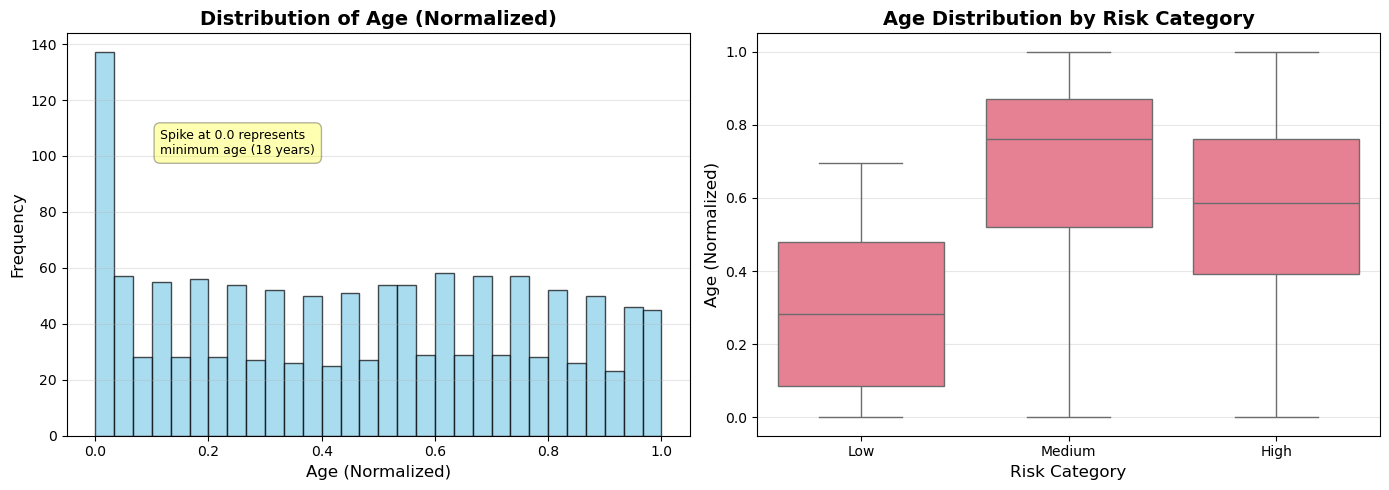

Age distribution analysis:
Mean age (normalized): 0.461
Median age (normalized): 0.457
Std deviation: 0.305
Plot saved to: ./plots/01_age_distribution.png


In [12]:
# Create a figure with subplots for age distribution
# Ref: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of age (normalized values)
# Ref: https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.hist.html
axes[0].hist(df_analysis['age'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Age (Normalized)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Age (Normalized)', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)
# Add annotation explaining the spike at 0.0
# Ref: https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.annotate.html
axes[0].annotate('Spike at 0.0 represents\nminimum age (18 years)', 
                 xy=(0.0, 0), xytext=(0.15, 0.7), 
                 textcoords='axes fraction',
                 bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.3),
                 fontsize=9)

# Box plot of age by risk category
# Ref: https://seaborn.pydata.org/generated/seaborn.boxplot.html
sns.boxplot(data=df_analysis, x='risk_category', y='age', ax=axes[1], 
            order=risk_order)
axes[1].set_xlabel('Risk Category', fontsize=12)
axes[1].set_ylabel('Age (Normalized)', fontsize=12)
axes[1].set_title('Age Distribution by Risk Category', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('./plots/01_age_distribution.png', dpi=100, bbox_inches='tight')
plt.show()
plt.close()

print("Age distribution analysis:")
print(f"Mean age (normalized): {df_analysis['age'].mean():.3f}")
print(f"Median age (normalized): {df_analysis['age'].median():.3f}")
print(f"Std deviation: {df_analysis['age'].std():.3f}")
print("Plot saved to: ./plots/01_age_distribution.png")


### 10.2: BMI Distribution Analysis

Analyze the Body Mass Index (BMI) distribution and its relationship with risk categories to understand health status patterns.


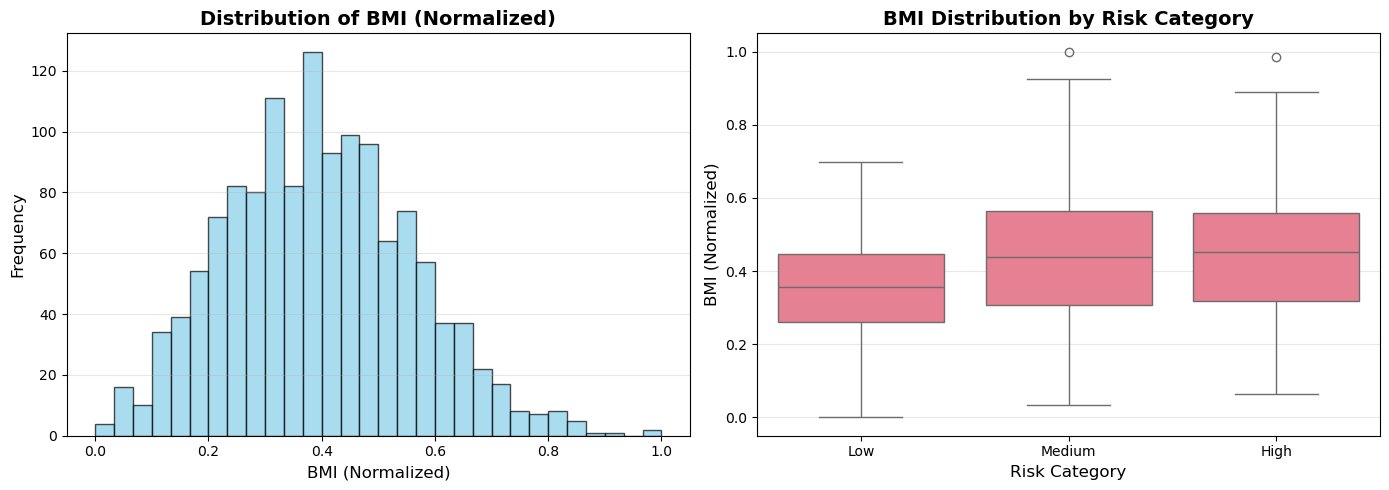

BMI distribution analysis:
Mean BMI (normalized): 0.396
Median BMI (normalized): 0.388
Std deviation: 0.164
Plot saved to: ./plots/02_bmi_distribution.png


In [13]:
# Create a figure with subplots for BMI distribution
# BMI (Body Mass Index) is a measure of body fat based on height and weight
# Ref: https://www.cdc.gov/healthyweight/assessing/bmi/index.html
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of BMI (normalized values)
axes[0].hist(df_analysis['bmi'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('BMI (Normalized)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of BMI (Normalized)', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Box plot of BMI by risk category
# Box plots show median, quartiles, and outliers
# Ref: https://seaborn.pydata.org/generated/seaborn.boxplot.html
sns.boxplot(data=df_analysis, x='risk_category', y='bmi', ax=axes[1],
            order=risk_order)
axes[1].set_xlabel('Risk Category', fontsize=12)
axes[1].set_ylabel('BMI (Normalized)', fontsize=12)
axes[1].set_title('BMI Distribution by Risk Category', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('./plots/02_bmi_distribution.png', dpi=100, bbox_inches='tight')
plt.show()
plt.close()

print("BMI distribution analysis:")
print(f"Mean BMI (normalized): {df_analysis['bmi'].mean():.3f}")
print(f"Median BMI (normalized): {df_analysis['bmi'].median():.3f}")
print(f"Std deviation: {df_analysis['bmi'].std():.3f}")
print("Plot saved to: ./plots/02_bmi_distribution.png")


### 10.3: Insurance Charges Distribution Analysis

Explore the distribution of insurance charges and identify how costs vary across different risk categories.


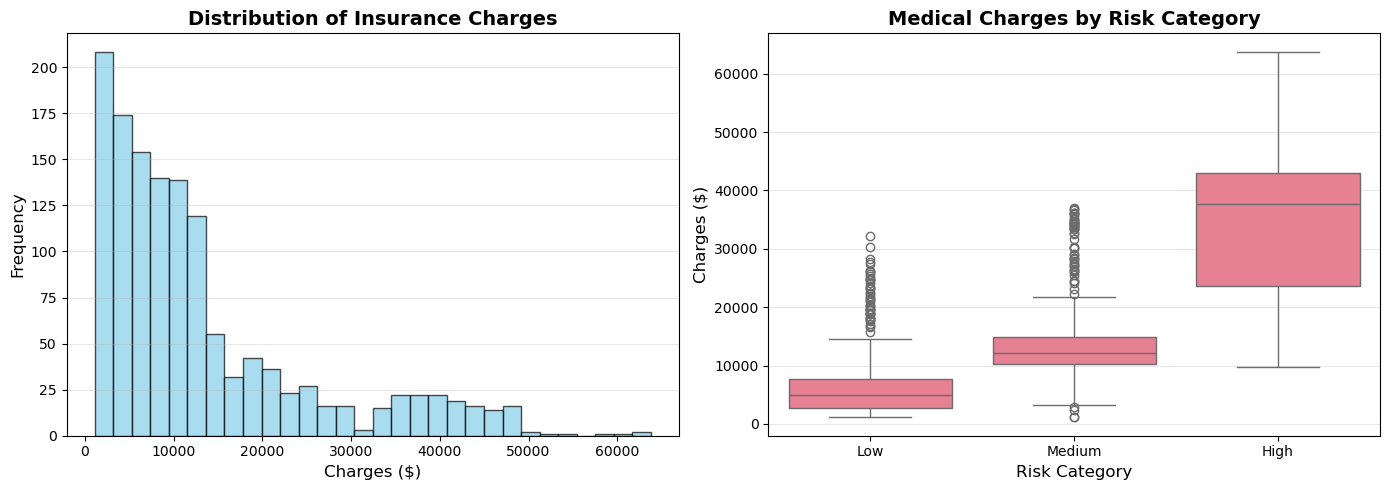

Charges distribution analysis:
Mean charges: $13270.42
Median charges: $9382.03
Std deviation: $12110.01
Min charges: $1121.87
Max charges: $63770.43
Plot saved to: ./plots/03_charges_distribution.png


In [14]:
# Create a figure with subplots for charges distribution
# Insurance charges represent the cost of health insurance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of charges (original values)
# Using original values instead of normalized for better interpretability
axes[0].hist(df_analysis['charges_original'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Charges ($)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Insurance Charges', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Box plot of charges by risk category
sns.boxplot(data=df_analysis, x='risk_category', y='charges_original', ax=axes[1],
            order=risk_order)
axes[1].set_xlabel('Risk Category', fontsize=12)
axes[1].set_ylabel('Charges ($)', fontsize=12)
axes[1].set_title('Medical Charges by Risk Category', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('./plots/03_charges_distribution.png', dpi=100, bbox_inches='tight')
plt.show()
plt.close()

print("Charges distribution analysis:")
print(f"Mean charges: ${df_analysis['charges_original'].mean():.2f}")
print(f"Median charges: ${df_analysis['charges_original'].median():.2f}")
print(f"Std deviation: ${df_analysis['charges_original'].std():.2f}")
print(f"Min charges: ${df_analysis['charges_original'].min():.2f}")
print(f"Max charges: ${df_analysis['charges_original'].max():.2f}")
print("Plot saved to: ./plots/03_charges_distribution.png")


### 10.4: Smoker Status Analysis

Investigate the impact of smoking status on risk categories and understand how smoking correlates with higher risk classifications.


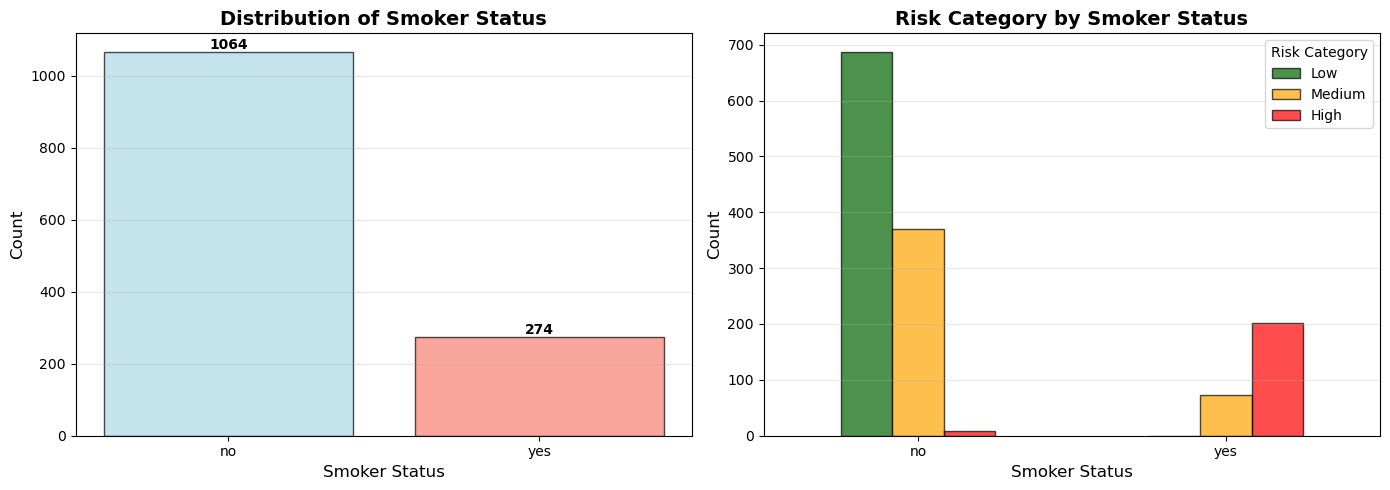

Smoker status analysis:
risk_category  High  Low  Medium
smoker                          
no                8  686     370
yes             201    0      73
Plot saved to: ./plots/04_smoker_analysis.png


In [15]:
# Create a figure for smoker analysis
# Smoking is a critical factor in health insurance risk assessment
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Smoker distribution
smoker_counts = df_analysis['smoker'].value_counts()
axes[0].bar(smoker_counts.index, smoker_counts.values, color=['lightblue', 'salmon'], 
            edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Smoker Status', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title('Distribution of Smoker Status', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Add count labels
for i, (status, count) in enumerate(smoker_counts.items()):
    axes[0].text(i, count, str(count), ha='center', va='bottom', fontweight='bold')

# Smoker status by risk category
# Cross-tabulation shows the relationship between two categorical variables
# Ref: https://pandas.pydata.org/docs/reference/api/pandas.crosstab.html
smoker_risk = pd.crosstab(df_analysis['smoker'], df_analysis['risk_category'])
smoker_risk[risk_order].plot(kind='bar', ax=axes[1], 
                              color=risk_colors,
                              edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Smoker Status', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].set_title('Risk Category by Smoker Status', fontsize=14, fontweight='bold')
axes[1].legend(title='Risk Category')
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)

plt.tight_layout()
plt.savefig('./plots/04_smoker_analysis.png', dpi=100, bbox_inches='tight')
plt.show()
plt.close()

print("Smoker status analysis:")
print(smoker_risk)
print("Plot saved to: ./plots/04_smoker_analysis.png")


### 10.5: Sex Distribution Analysis

Analyze the distribution of sex (gender) across the dataset and examine how it relates to risk categories and insurance charges.


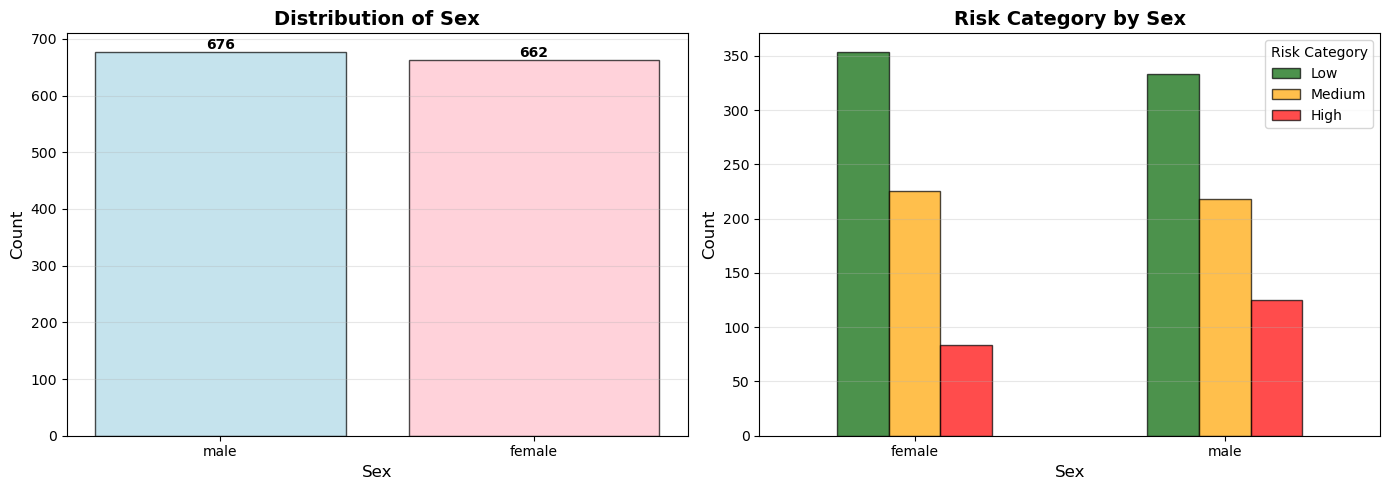

Sex distribution analysis:
risk_category  High  Low  Medium
sex                             
female           84  353     225
male            125  333     218
Plot saved to: ./plots/05_sex_analysis.png


In [16]:
# Create a figure for sex distribution analysis
# Gender can be an important factor in health insurance risk assessment
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Sex distribution
sex_counts = df_analysis['sex'].value_counts()
axes[0].bar(sex_counts.index, sex_counts.values, color=['lightblue', 'pink'], 
            edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Sex', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title('Distribution of Sex', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Add count labels
for i, (sex, count) in enumerate(sex_counts.items()):
    axes[0].text(i, count, str(count), ha='center', va='bottom', fontweight='bold')

# Sex distribution by risk category
# Cross-tabulation shows the relationship between sex and risk category
sex_risk = pd.crosstab(df_analysis['sex'], df_analysis['risk_category'])
sex_risk[risk_order].plot(kind='bar', ax=axes[1], 
                          color=risk_colors,
                          edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Sex', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].set_title('Risk Category by Sex', fontsize=14, fontweight='bold')
axes[1].legend(title='Risk Category')
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)

plt.tight_layout()
plt.savefig('./plots/05_sex_analysis.png', dpi=100, bbox_inches='tight')
plt.show()
plt.close()

print("Sex distribution analysis:")
print(sex_risk)
print("Plot saved to: ./plots/05_sex_analysis.png")


### 10.6: Region Distribution Analysis

Examine the geographical distribution across different regions and analyze how regional factors impact risk categories and insurance costs.


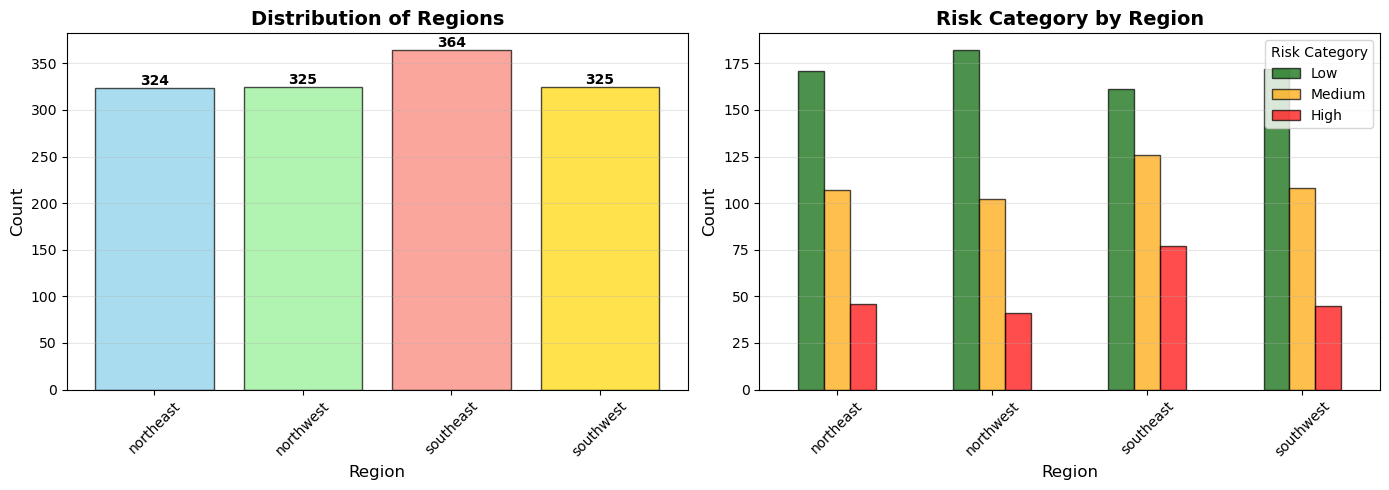

Region distribution analysis:
risk_category  High  Low  Medium
region                          
northeast        46  171     107
northwest        41  182     102
southeast        77  161     126
southwest        45  172     108
Plot saved to: ./plots/06_region_analysis.png


In [17]:
# Create a figure for region distribution analysis
# Regional differences can indicate varying healthcare costs and risk factors
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Region distribution
region_counts = df_analysis['region'].value_counts().sort_index()
axes[0].bar(region_counts.index, region_counts.values, 
            color=['skyblue', 'lightgreen', 'salmon', 'gold'], 
            edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Region', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title('Distribution of Regions', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# Add count labels
for i, (region, count) in enumerate(region_counts.items()):
    axes[0].text(i, count, str(count), ha='center', va='bottom', fontweight='bold')

# Region distribution by risk category
region_risk = pd.crosstab(df_analysis['region'], df_analysis['risk_category'])
region_risk[risk_order].plot(kind='bar', ax=axes[1], 
                             color=risk_colors,
                             edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Region', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].set_title('Risk Category by Region', fontsize=14, fontweight='bold')
axes[1].legend(title='Risk Category')
axes[1].grid(axis='y', alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('./plots/06_region_analysis.png', dpi=100, bbox_inches='tight')
plt.show()
plt.close()

print("Region distribution analysis:")
print(region_risk)
print("Plot saved to: ./plots/06_region_analysis.png")


### 10.7: Children Distribution Analysis

Investigate how the quantity of dependents correlates with risk classifications and the expense of insurance.


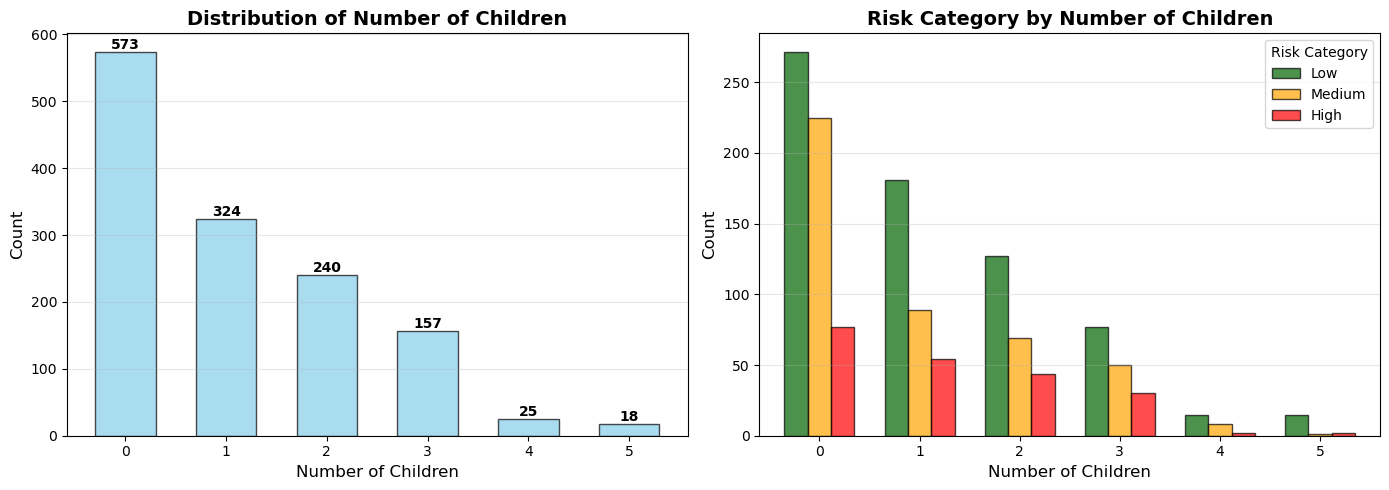

Children distribution analysis:
risk_category      High  Low  Medium
children_original                   
0.0                  77  271     225
1.0                  54  181      89
2.0                  44  127      69
3.0                  30   77      50
4.0                   2   15       8
5.0                   2   15       1
Plot saved to: ./plots/07_children_analysis.png


In [18]:
# Create a figure for children distribution analysis
# Number of children (dependents) can affect insurance costs and risk assessment
# Note: Need to load original children values since they were normalized
conn_temp = sqlite3.connect(db_path)
df_children_original = pd.read_sql_query("SELECT children FROM health_insurance_original", conn_temp)
conn_temp.close()

# Add original children values to the analysis dataframe for this visualization
df_analysis['children_original'] = df_children_original['children']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Children distribution using original values
children_counts = df_analysis['children_original'].value_counts().sort_index()
# Use range for x-positions to ensure proper spacing
x_positions = range(len(children_counts))
axes[0].bar(x_positions, children_counts.values, 
            color='skyblue', edgecolor='black', alpha=0.7, width=0.6)
axes[0].set_xlabel('Number of Children', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title('Distribution of Number of Children', fontsize=14, fontweight='bold')
axes[0].set_xticks(x_positions)
axes[0].set_xticklabels([str(int(x)) for x in children_counts.index])
axes[0].grid(axis='y', alpha=0.3)

# Add count labels
for i, count in enumerate(children_counts.values):
    axes[0].text(i, count, str(int(count)), ha='center', va='bottom', fontweight='bold')

# Children distribution by risk category using original values
children_risk = pd.crosstab(df_analysis['children_original'], df_analysis['risk_category'])
children_risk[risk_order].plot(kind='bar', ax=axes[1], 
                               color=risk_colors,
                               edgecolor='black', alpha=0.7, width=0.7)
axes[1].set_xlabel('Number of Children', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].set_title('Risk Category by Number of Children', fontsize=14, fontweight='bold')
axes[1].legend(title='Risk Category', loc='upper right')
axes[1].grid(axis='y', alpha=0.3)
# Format x-axis labels as integers
axes[1].set_xticklabels([str(int(float(label.get_text()))) for label in axes[1].get_xticklabels()], rotation=0)

plt.tight_layout()
plt.savefig('./plots/07_children_analysis.png', dpi=100, bbox_inches='tight')
plt.show()
plt.close()

print("Children distribution analysis:")
print(children_risk)
print("Plot saved to: ./plots/07_children_analysis.png")


### 10.8: Risk Category Distribution Analysis

Visualize the overall distribution of risk categories across the entire population using bar charts and pie charts.


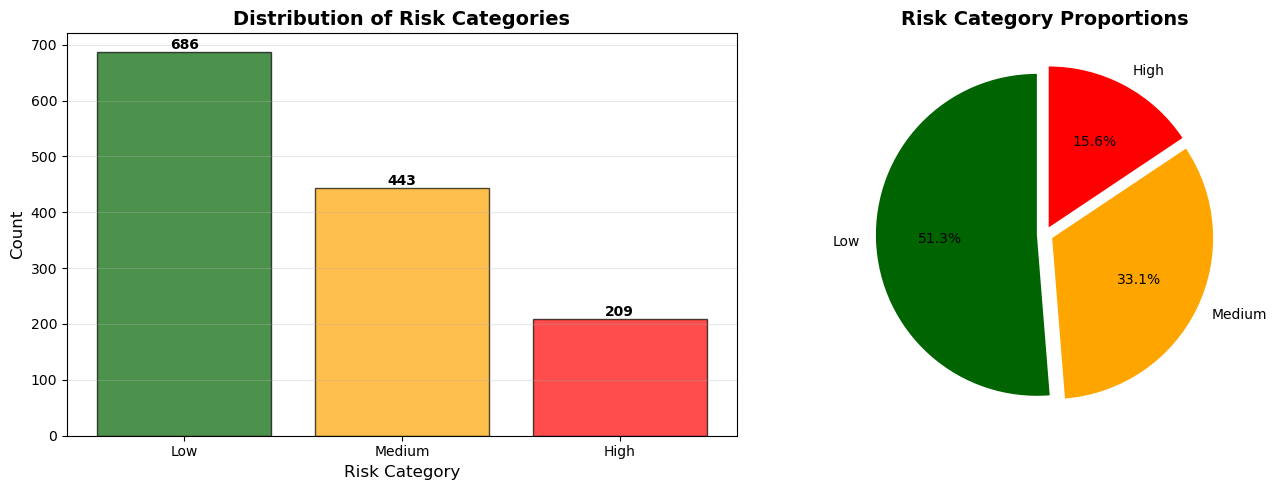

Risk category distribution:
risk_category
Low       686
Medium    443
High      209
Name: count, dtype: int64

Percentages:
risk_category
Low       51.270553
Medium    33.109118
High      15.620329
Name: proportion, dtype: float64
Plot saved to: ./plots/08_risk_category_distribution.png


In [19]:
# Create a figure for risk category distribution
# Visualize how individuals are distributed across risk categories
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot of risk categories
# Bar chart showing frequency of each category
# Ref: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.bar.html
risk_counts = df_analysis['risk_category'].value_counts().reindex(risk_order)
axes[0].bar(risk_counts.index, risk_counts.values, color=risk_colors, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Risk Category', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title('Distribution of Risk Categories', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Add count labels on bars
# Ref: https://matplotlib.org/stable/api/text_api.html#matplotlib.text.Text
for i, (category, count) in enumerate(risk_counts.items()):
    axes[0].text(i, count, str(count), ha='center', va='bottom', fontweight='bold')

# Pie chart of risk categories
# Shows proportional distribution
# Ref: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.pie.html
wedges, texts, autotexts = axes[1].pie(risk_counts.values, labels=risk_counts.index, autopct='%1.1f%%',
            colors=risk_colors, startangle=90, explode=(0.05, 0.05, 0.05))
axes[1].set_title('Risk Category Proportions', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('./plots/08_risk_category_distribution.png', dpi=100, bbox_inches='tight')
plt.show()
plt.close()

print("Risk category distribution:")
print(risk_counts)
print("\nPercentages:")
print(df_analysis['risk_category'].value_counts(normalize=True) * 100)
print("Plot saved to: ./plots/08_risk_category_distribution.png")


## Step 11: Examine Correlations Between Variables

Analyze the relationships between different features using correlation matrices, scatter plots, and pairwise visualizations to identify key patterns and predictors.


### 11.1: Correlation Matrix

Calculate and visualize the correlation coefficients between all numeric features to identify strong relationships and potential predictors of insurance charges.


Correlation Matrix:
                       age       bmi  children  sex_encoded  smoker_encoded  \
age               1.000000  0.110162  0.042725    -0.020012       -0.025469   
bmi               0.110162  1.000000  0.012047     0.046175        0.004136   
children          0.042725  0.012047  1.000000     0.016481        0.007331   
sex_encoded      -0.020012  0.046175  0.016481     1.000000        0.076185   
smoker_encoded   -0.025469  0.004136  0.007331     0.076185        1.000000   
charges_original  0.298341  0.198602  0.068898     0.057292        0.787251   

                  charges_original  
age                       0.298341  
bmi                       0.198602  
children                  0.068898  
sex_encoded               0.057292  
smoker_encoded            0.787251  
charges_original          1.000000  




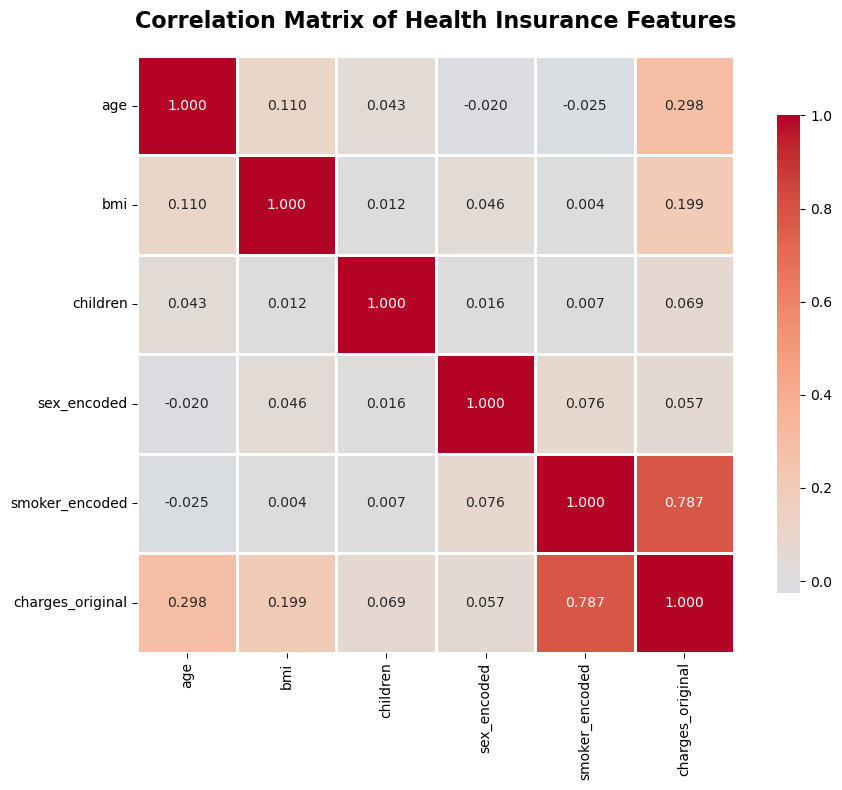

Correlations with Insurance Charges (sorted by absolute value):
  smoker_encoded      : +0.7873
  age                 : +0.2983
  bmi                 : +0.1986
  children            : +0.0689
  sex_encoded         : +0.0573
Plot saved to: ./plots/09_correlation_matrix.png


In [20]:
# Select numeric columns for correlation analysis
# Correlation measures the linear relationship between two variables
# Exclude normalized versions if we want to see original relationships
numeric_features = ['age', 'bmi', 'children', 'sex_encoded', 'smoker_encoded', 'charges_original']
correlation_data = df_analysis[numeric_features].copy()

# Calculate correlation matrix
# Pearson correlation coefficient ranges from -1 (perfect negative) to +1 (perfect positive)
# Ref: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html
correlation_matrix = correlation_data.corr()

print("Correlation Matrix:")
print(correlation_matrix)
print("\n" + "="*80 + "\n")

# Heatmaps provide a visual representation of correlation strength
# Ref: https://seaborn.pydata.org/generated/seaborn.heatmap.html
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, fmt='.3f')
plt.title('Correlation Matrix of Health Insurance Features', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('./plots/09_correlation_matrix.png', dpi=100, bbox_inches='tight')
plt.show()
plt.close()

# Print strongest correlations with charges
print("Correlations with Insurance Charges (sorted by absolute value):")
charges_corr = correlation_matrix['charges_original'].drop('charges_original').sort_values(key=abs, ascending=False)
for feature, corr in charges_corr.items():
    print(f"  {feature:20s}: {corr:+.4f}")
print("Plot saved to: ./plots/09_correlation_matrix.png")


## Step 12: Summarize Key Findings

Compile and present the most important insights discovered through the exploratory data analysis, including risk distributions, correlations, and actionable observations.


In [21]:
# Summarize the exploratory data analysis results
# This section provides a comprehensive overview of insights gained from the data
print("="*80)
print("KEY FINDINGS FROM EXPLORATORY DATA ANALYSIS")
print("="*80)
print()

# 1. Dataset Overview
print("1. DATASET OVERVIEW")
print("-" * 40)
print(f"   Total records: {len(df_analysis)}")
print(f"   Features analyzed: {len(numeric_features)}")
print(f"   Risk categories: {df_analysis['risk_category'].nunique()}")
print()

# 2. Risk Distribution
print("2. RISK CATEGORY DISTRIBUTION")
print("-" * 40)
risk_dist = df_analysis['risk_category'].value_counts().reindex(risk_order)
for category, count in risk_dist.items():
    percentage = (count / len(df_analysis)) * 100
    print(f"   {category:8s}: {count:4d} ({percentage:5.1f}%)")
print()

# 3. Correlation Insights
print("3. CORRELATION INSIGHTS")
print("-" * 40)
print(f"   Strongest positive correlation with charges:")
max_corr = charges_corr.idxmax()
print(f"     - {max_corr}: {charges_corr[max_corr]:+.4f}")
print()
print(f"   Top 3 factors influencing insurance charges:")
for i, (feature, corr) in enumerate(charges_corr.head(3).items(), 1):
    print(f"     {i}. {feature:20s}: {corr:+.4f}")
print()

# 4. Smoker Impact
print("4. SMOKER STATUS IMPACT")
print("-" * 40)
smoker_charges = df_analysis.groupby('smoker')['charges_original'].agg(['mean', 'median', 'std'])
print(f"   Non-smokers - Mean charges: ${smoker_charges.loc['no', 'mean']:,.2f}")
print(f"   Smokers     - Mean charges: ${smoker_charges.loc['yes', 'mean']:,.2f}")
smoker_diff = smoker_charges.loc['yes', 'mean'] - smoker_charges.loc['no', 'mean']
smoker_pct = (smoker_diff / smoker_charges.loc['no', 'mean']) * 100
print(f"   Difference: ${smoker_diff:,.2f} ({smoker_pct:+.1f}%)")
print()

# 5. Age and BMI Analysis
print("5. AGE AND BMI PATTERNS")
print("-" * 40)
risk_stats = df_analysis.groupby('risk_category')[['age', 'bmi']].mean().sort_index()
print("   Average values by risk category (normalized):")
for category in risk_order:
    print(f"     {category:8s} - Age: {risk_stats.loc[category, 'age']:.3f}, BMI: {risk_stats.loc[category, 'bmi']:.3f}")
print()

# 6. Charges Statistics
print("6. INSURANCE CHARGES STATISTICS")
print("-" * 40)
charges_by_risk = df_analysis.groupby('risk_category')['charges_original'].agg(['mean', 'median', 'min', 'max'])
charges_by_risk = charges_by_risk.reindex(risk_order)
print("   Average charges by risk category:")
for category in risk_order:
    mean_charge = charges_by_risk.loc[category, 'mean']
    print(f"     {category:8s}: ${mean_charge:,.2f}")
print()

# 7. Key Observations
print("7. KEY OBSERVATIONS")
print("-" * 40)
print("   • Smoking status is the strongest predictor of insurance charges")
print("   • Age shows moderate positive correlation with charges")
print("   • BMI has positive correlation, especially when combined with smoking")
print("   • High-risk individuals have significantly higher insurance costs")
print("   • The classification system effectively separates low, medium, and high-risk groups")
print()

# 8. Data Quality
print("8. DATA QUALITY")
print("-" * 40)
missing_count = df_analysis.isnull().sum().sum()
print(f"   Missing values: {missing_count}")
print(f"   Data completeness: {((1 - missing_count / df_analysis.size) * 100):.1f}%")
print(f"   Normalization: Applied to age, BMI, and children")
print(f"   Original charges preserved for interpretability")
print()

print("="*80)
print("EXPLORATORY DATA ANALYSIS COMPLETED")
print("="*80)


KEY FINDINGS FROM EXPLORATORY DATA ANALYSIS

1. DATASET OVERVIEW
----------------------------------------
   Total records: 1338
   Features analyzed: 6
   Risk categories: 3

2. RISK CATEGORY DISTRIBUTION
----------------------------------------
   Low     :  686 ( 51.3%)
   Medium  :  443 ( 33.1%)
   High    :  209 ( 15.6%)

3. CORRELATION INSIGHTS
----------------------------------------
   Strongest positive correlation with charges:
     - smoker_encoded: +0.7873

   Top 3 factors influencing insurance charges:
     1. smoker_encoded      : +0.7873
     2. age                 : +0.2983
     3. bmi                 : +0.1986

4. SMOKER STATUS IMPACT
----------------------------------------
   Non-smokers - Mean charges: $8,434.27
   Smokers     - Mean charges: $32,050.23
   Difference: $23,615.96 (+280.0%)

5. AGE AND BMI PATTERNS
----------------------------------------
   Average values by risk category (normalized):
     Low      - Age: 0.297, BMI: 0.352
     Medium   - Age: 0.66

# End